# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python.

## Environment
- Platform: Google Colab, CPU runtime (no GPU).
- Set a global random seed for reproducibility (e.g., np.random.seed(42)).


## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise. Fill in the missing parts (TODO) in the linear_models.py file and int this notebook.
2. Write **efficient vectorized** code whenever instructed.
3. You are responsible for the correctness of your code and should add as many tests as you see fit (tests will not be graded nor checked).
4. Do not change the functions we provided you.
5. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
6. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors.
7. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).


## Submission guidelines:
- What to submit: only a zip named HW1_<YOUR_ID>.zip containing: (1) hw1.ipynb (2) linear_models.py
- Your submitted notebook should **run without problems**.
- Please submit your **executed** (fully run) notebook, including all outputs (plots, printed results, etc.). Make sure that all cells have been run in order from top to bottom before submission.

## Academic integrity

You may discuss ideas, but all submitted code must be your own. Cite any external snippets.

Q: How do I make sure everything works before I submit?

A: You should restart your kernel and rerun all cells. Make sure you get the desired output and that you meet exercise requirements. **This is an important step. You should include your desired outputs in the output cells to make your code easier to understand.**

Q: Changes I do to the code in the linear_models.py file don't update in the ipynb file.

A: Instead of doing:

```
from linear_models import LinearClassification
...
linear_classification = LinearClassification(...)
```
In your code just use:
```
linear_classification = linear_models.LinearClassification(...)
```
This will cause the changes to load automatically into the notebook (if you ran the cell with the ```watch_module``` function)


## Setting up the project folder


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import sys
import os

# TODO: Replace 'your_project_folder' with the actual path to your project folder in Google Drive
project_folder = '/content/drive/MyDrive/Colab Notebooks'
sys.path.append(project_folder)

print(f"Added {project_folder} to system path.")

Added /content/drive/MyDrive/Colab Notebooks to system path.


In [29]:
# Set up automatic reloading for linear_models.py
import importlib
import threading
import time

# TODO: Ensure linear_models.py is in the project_folder specified above
module_name = 'linear_models'
module_path = os.path.join(project_folder, f'{module_name}.py')

def watch_module(module, path, interval=2):
    last_mtime = os.path.getmtime(path)
    def watch():
        nonlocal last_mtime
        while True:
            try:
                mtime = os.path.getmtime(path)
                if mtime > last_mtime:
                    importlib.reload(module)
                    print(f"[auto-reloaded {module.__name__}]")
                    last_mtime = mtime
            except Exception as e:
                print(e)
            time.sleep(interval)
    threading.Thread(target=watch, daemon=True).start()

try:
    # Import the module initially
    linear_models = importlib.import_module(module_name)
    print(f"Imported {module_name}.")
    # Start watching the module file for changes
    watch_module(linear_models, module_path)
    print(f"✅ Watching {module_path} for changes.")
except ImportError:
    print(f"Error: Could not import module {module_name}. Make sure '{module_path}' exists and contains the module.")
except FileNotFoundError:
     print(f"Error: Module file not found at '{module_path}'. Make sure the path is correct.")

Imported linear_models.
✅ Watching /content/drive/MyDrive/Colab Notebooks/linear_models.py for changes.


## Imports

In [30]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools
import time
# from linear_models import * # It is okay if you get "import cannot be resolved"
import linear_models
import importlib
importlib.reload(linear_models)
from google.colab import drive
import threading
from typing import Dict, Tuple, Iterable, Optional, Any


# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [31]:
### Blank cell for pip install
### EXAMPLE
# %pip install numpy (in some platforms or versions you will need to use '!' instead of '%'. like this - !pip install numpy)


### Make sure to restart the note book after the installs ###

# Data preprocessing

## Data download and processing Helper Code

In [32]:
def download_and_extract(url, download_dir):
    """
    Download and extract the CIFAR-10 dataset if it doesn't already exist.

    Parameters
    ----------
    url : str
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    download_dir : str
        Directory where the downloaded file will be saved and extracted.
        Example: "data/CIFAR-10/"

    Returns
    -------
    None
    """

    # Determine filename and full path where the file will be saved
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if dataset is already downloaded (and extracted)
    if not os.path.exists(file_path):
       # Create the directory if it doesn’t exist
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the dataset
        print("Downloading, This might take several minutes.")
        last_update_time = time.time()
        file_path, _ = urllib.request.urlretrieve(url=url, filename=file_path)

        print()
        print("Download finished. Extracting files.")

        # Extract the dataset
        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done. Dataset is ready!")
    else:
        print("Dataset already downloaded and unpacked.")
        print("If something seems wrong, delete the folder and re-run.")


def load_CIFAR_batch(filename):
    ''' Load a single batch of the CIFAR-10 dataset.'''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']

        # Reshape and transpose: original shape (10000, 3072)
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load(ROOT):
    ''' Load all training and test batches of CIFAR-10.'''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

In this section, we will download and extract the **CIFAR-10** dataset if it is not already available locally.

- The dataset will be saved under: `datasets/cifar10/`
- If it’s already there, the script will **skip downloading**.
- This process may take a few minutes the first time you run it.

In [33]:
# ---------------------------------------------------------------------
# Data Download (Run once)
# ---------------------------------------------------------------------
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/'
download_and_extract(URL, PATH)

Dataset already downloaded and unpacked.
If something seems wrong, delete the folder and re-run.


In [34]:
# ---------------------------------------------------------------------
# Load the full CIFAR-10 dataset from local path
# ---------------------------------------------------------------------
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH)  # load the entire data

### ❀ Q1: Exploratory Data Analysis (EDA) ❀

Use the uplodaed **CIFAR-10** dataset.
1. Print the **shapes** of the training and test sets.
2. Display the **number of classes** and their names.
3. Show the **class distribution** in the training set.

**(5 points)**

In [35]:
# TODO - your answer


#(1)
print("X_train dimension: ", X_train.shape,"\n")
print("y_train.shape :", y_train.shape, "\n")
print("X_test dimension: ", X_test.shape, "\n")
print("y_test dimesion: ", y_test.shape, "\n")
#(2)
print("Number of classes: ", len(np.unique(y_train)), "\n")
print("Classes Names: ", np.unique(y_train), "\n")
#(3)

size = y_train.size
classes, distr = np.unique(y_train, return_counts=True)
print("Classes: ", classes)
print("Distribution: ", (distr/size))

X_train dimension:  (50000, 32, 32, 3) 

y_train.shape : (50000,) 

X_test dimension:  (10000, 32, 32, 3) 

y_test dimesion:  (10000,) 

Number of classes:  10 

Classes Names:  [0 1 2 3 4 5 6 7 8 9] 

Classes:  [0 1 2 3 4 5 6 7 8 9]
Distribution:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


## Data Preprocessing Part 1

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization.





In [36]:
# ---------------------------------------------------------------------
# Filter the dataset to include only the target classes
# ------------------------------------------/---------------------------
TARGET_CLASSES = [2, 3, 4]
classes = ['bird', 'cat', 'deer']
train_mask = np.isin(y_train, TARGET_CLASSES)
test_mask  = np.isin(y_test,  TARGET_CLASSES)

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test  = X_test[test_mask]
y_test  = y_test[test_mask]

# ---------------------------------------------------------------------
# Relabel to {0,1,2} so predictions match labels
# ---------------------------------------------------------------------
label_map = {orig: i for i, orig in enumerate(TARGET_CLASSES)}
y_train = np.vectorize(label_map.get)(y_train)
y_test  = np.vectorize(label_map.get)(y_test)

# ------------------------------------------------------------
# Define sizes for training / validation / test splits
# ------------------------------------------------------------
num_training   = 10000
num_validation = 1000
num_testing    = 1000

# ---------------------------------------------------------------------
# Create subset
# ---------------------------------------------------------------------

# Training subset
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Validation subset
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]

# Test subset
mask = range(num_validation, num_validation + num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# ---------------------------------------------------------------------
# Convert to float64 (optional)
# ---------------------------------------------------------------------
X_train = X_train.astype(np.float64)
X_val   = X_val.astype(np.float64)
X_test  = X_test.astype(np.float64)

print("Shapes ->",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_val",   X_val.shape,   "y_val",   y_val.shape,
      "X_test",  X_test.shape,  "y_test",  y_test.shape)

Shapes -> X_train (10000, 32, 32, 3) y_train (10000,) X_val (1000, 32, 32, 3) y_val (1000,) X_test (1000, 32, 32, 3) y_test (1000,)


In [37]:
def get_batch(X, y, n=1000):
    "Randomly select a batch of samples from the dataset."
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels


def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    "Create a grid of random images (or flattened vectors) from dataset."
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print('\t'.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid


def vec_2_img(x):
    """ Convert a flattened CIFAR-10 image vector back to a (32, 32, 3) RGB image.
    Removes bias term if present."""
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

      cat	     bird	      cat	     bird


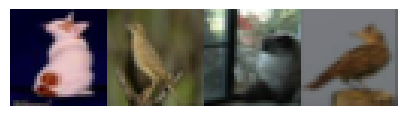

In [38]:
# quick sanity check preview
X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, n=4, convert_to_image=False))
plt.axis("off")
plt.show()

## Data Preprocessing Part 2

In this section, we apply several image preprocessing steps to prepare the data for our linear models:

1. Mean Subtraction - We subtract the mean image (computed over the training set) from every image.

2. Flattening - Each image originally has the shape (32 × 32 × 3).
We flatten it into a single vector of 3072 features.

3. Bias Trick - We append an additional constant feature (set to 1) to every image vector.

In [39]:
# =========================
# Final data preprocessing
# =========================

# 1) subtract the TRAIN mean image (feature-wise)
mean_image = np.mean(X_train, axis=0, keepdims=True)
X_train = X_train - mean_image
X_val   = X_val   - mean_image
X_test  = X_test  - mean_image

# 2) flatten HxWxC -> D
X_train = X_train.reshape(X_train.shape[0], -1)
X_val   = X_val.reshape(X_val.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

# 3) add a bias term (last feature = 1)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val   = np.hstack([X_val,   np.ones((X_val.shape[0],   1))])
X_test  = np.hstack([X_test,  np.ones((X_test.shape[0],  1))])

print(f"Shape of Training Set: {X_train.shape}")   # (N_train, D+1)
print(f"Shape of Validation Set: {X_val.shape}")   # (N_val,   D+1)
print(f"Shape of Test Set: {X_test.shape}")        # (N_test,  D+1)

# Ensure labels are 0..C-1
num_classes = int(np.max(y_train)) + 1
assert set(np.unique(y_train)) <= set(range(num_classes)), "y must be in 0..C-1"

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


### ❀ Q2: Understanding the Image Preprocessing ❀

Before moving on, let’s review the preprocessing steps applied to our dataset.

Answer the following questions:

1. Mean Subtraction

- Why do we subtract the mean image (computed from the training set) from every image?

2. Flattening

- Why do we need to flatten the images into 3072-dimensional vectors before training a linear model?


3. Bias Trick

- Why do we add a constant 1 to every image vector (known as the bias trick)?

**(5 points)**



TODO - your answer

1.  Subtracting the mean is a normalisation step, it centers the data thereby stabalizing and accelerating the training and also reduces the unecessary biases thus improving gradient flow.

2. A linear Model is of the form y = f(x) = Wx + b, our CIPHER is of dimension: 32 x 32 x 3 features so to make the model work we just create a mapping from CIPHER to column vector of the same number of features.

3. The bias term is the offset, in the linear model (our b in this case), if we don't add this term then our model must always go through the origin, which isn't always the case and so it may not learn correctly. By adding a bias, the model can shift the boundary to fit the data properly, allowing it to learn more flexible and accurate classifiers.


# Linear classifier: mapping images to scores

- During this exercise, we will maintain a python class with basic functionality (such as training the model).

- The linear classifiers we will build will inherit some functionality from that class and will change several functions (such as the loss function, for example).

- Read the code in the next cell and make sure you understand it.

- Need a quick Python OOP refresher? This short tutorial on classes and objects can help [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) .


**TODO:**  
Complete the missing code in the dedicated places in the linear_models.py file (Linear Classifier class).
- `train` **(10 points)**
- `calc_accuracy` **(5 points)**





## Linear perceptron

Our first linear classifier is the **Perceptron**, a foundational model in machine learning.

It computes a **linear score** for each class:

$$ f(x_i; W, b) = W \cdot x_i + b $$

- W : a weight matrix of shape *(num_features × num_classes)*  
- b : a bias term (included using the **bias trick**)

Each column in \( W \) corresponds to one class.  
The **final prediction** is the class with the **highest score**.

---

### Multiclass vs. Binary

- **Multiclass Case:**  
  `W` is a matrix. Each row corresponds to a feature, each column to a class.  
  Prediction is made via:

  $$ \hat{y_i} = \arg\max_j (W_j \cdot x_i) $$

- **Binary Case (special case of 2 classes):**  
  You can either:
  1. Treat it as a **2-class multiclass** problem (use 2 columns in `W`),  
     prediction = class with the highest score.  
  2. Or use a **single weight vector** `w`, where:
    $$ \text{predict } 1 \text{ if } w \cdot x + b > 0, \text{ else } 0 $$

In this exercise, our implementation is **multiclass**, supporting more than 2 classes.


### Objective

Your goal is to **learn** the parameters `W` and `b` such that the classifier correctly predicts the labels in the training set.  We’ll do this by **minimizing the Perceptron loss**, which penalizes misclassified examples.


**TODO:**  
We’ll now implement the `LinearPerceptron` class, which inherits from `LinearClassifier`.
Implement the `init` and the `predict` functions.


**(5 Points)**

In [40]:
classifier = linear_models.LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

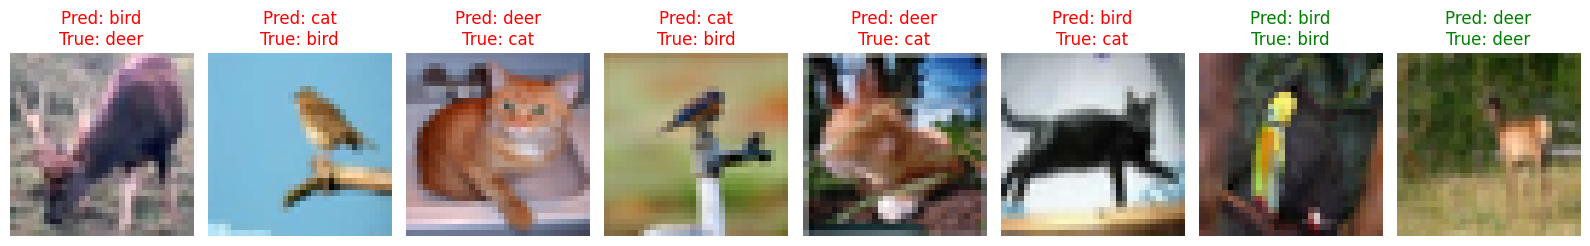

In [41]:
# ---------------------------------------------------------------------
# Visualization exmaple: Compare Predicted vs True Labels on Test Set
# ---------------------------------------------------------------------

num_show = 8 # you can change the num of exmaples
idxs = np.random.choice(len(X_test), size=num_show, replace=False)

fig, axes = plt.subplots(1, num_show, figsize=(16, 3))

mean_flat = mean_image.reshape(-1)
if mean_flat.size > 3072:
    mean_flat = mean_flat[:3072]
mean_img_3d = mean_flat.reshape(32, 32, 3)

for ax, i in zip(axes, idxs):
    vec = X_test[i].reshape(-1)
    if vec.size > 3072:
        vec = vec[:3072]   # strip bias
        img = vec[:3072].reshape(32, 32, 3) + mean_img_3d
        img = (img - img.min()) / (img.max() - img.min())  # scale to 0–1
    true_lbl = classes[y_test[i]]
    pred_lbl = classes[y_pred[i]]
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Pred: {pred_lbl}\nTrue: {true_lbl}",
                 color="green" if y_pred[i] == y_test[i] else "red")


plt.tight_layout()
plt.show()

## Evaluation

Use the class method `calc_accuracy`

In [42]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  0.3214


### ❀ Q3 ❀


Explain why the accuracy on the training dataset is low
**(5 points)**


Answer:
The Linear Classifier using the perceptron is too simple compared to the complexities of the data provided, this data contains non-Linear patterns, in which the perceptron aims to find a Linear boundary, as such this method isn't able to fully capture these complexities, which in turn leads to lower levels of accuracy.


## Perceptron loss

In this section, you’ll implement the **Perceptron loss**
- Notice the loss method for each class is just a call for the loss function written in the next cell.
- Once you are finished with implementation, everything should work.

TODO:

- First, complete the function `perceptron_loss_naive` in the linear_models.py file. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  

- Test your function using the following cells

**(15 points)**

In [43]:
W = np.random.randn(3073, 3) * 1e-4

In [44]:
# =========================
# Quick test
# =========================
%%time
loss_naive, grad_naive = linear_models.perceptron_loss_naive(W, X_val, y_val)
print("Loss:", loss_naive)

Number of features 3073

Loss: 1.0144370321592692e-10
CPU times: user 94 ms, sys: 0 ns, total: 94 ms
Wall time: 54.1 ms


**TODO:**

once your code works, complete the function `softmax_cross_entropy` and compare the results of the two functions using the cell below.

**(10 points)**

In [45]:
# =========================
# Quick test
# =========================
%%time
loss, _ = linear_models.softmax_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss))

loss: 1.130114
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 110 ms


Note:
- You might not see big changes in time due to other computing factors. In big enough datasets it would be crucial to a the vectorized version, which you will implement soon.

We have obtained an efficient function for loss and gradient calculation and we can now train our network.


In [46]:
%%time
perceptron = linear_models.LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7,
                                num_iters=1500, verbose=True)

iteration 0 / 1500: loss 2.528578
iteration 100 / 1500: loss 1.748584
iteration 200 / 1500: loss 1.551601
iteration 300 / 1500: loss 1.498030
iteration 400 / 1500: loss 1.355204
iteration 500 / 1500: loss 1.433983
iteration 600 / 1500: loss 1.449133
iteration 700 / 1500: loss 1.497787
iteration 800 / 1500: loss 1.365102
iteration 900 / 1500: loss 1.125556
iteration 1000 / 1500: loss 1.269283
iteration 1100 / 1500: loss 1.291280
iteration 1200 / 1500: loss 1.228520
iteration 1300 / 1500: loss 1.362546
iteration 1400 / 1500: loss 1.097366
CPU times: user 32 s, sys: 58.1 ms, total: 32 s
Wall time: 33.3 s


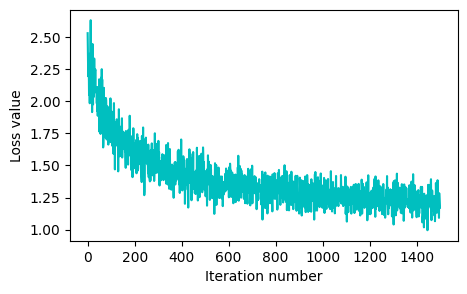

In [47]:
plt.plot(loss_history, color='c')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [48]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.4735
Testing accuracy:  0.464


## Hyperparameter optimization


Now that your model achieves reasonable accuracy (around 50% → 75%), it’s time to tune your hyperparameters to get the best possible performance.

Complete the `tune_parameters` function inside the `linear_models.py` file.

TODO:

1. Explore different hyperparameter combinations — specifically:

- Learning rate (e.g., [1e-3, 1e-2, 1e-1])

- Batch size (e.g., [32, 64, 128])

2. Train a new model for each combination using the training set.

3. Evaluate each model on the validation set.

4. Record your results in a dictionary of the form:

`results = {
    (learning_rate, batch_size): (train_acc, val_acc),
    ...
}`


5. After finishing your search, select the best-performing configuration (based on validation accuracy).

6. Finally, retrain your model with this configuration and evaluate it on the test set.

\
Tip: Start with a small number of iterations to debug your code quickly. Once everything works, increase num_iters to get stable results.

\
Goal:
Identify the combination of learning rate and batch size that leads to the highest validation accuracy, then report its training, validation, and test performance.

**(10 points)**


In [50]:
import linear_models

learning_rates = [1e-3, 1e-2, 1e-1]
batch_sizes    = [32, 64, 128, 256]

results, best_perc, best_val = linear_models.tune_perceptron(
    linear_models.LinearPerceptron,
    X_train, y_train, X_val, y_val,
    learning_rates, batch_sizes,
    num_iters=500,
    model_kwargs=None,
    verbose=True,  # notebook printing here, not inside autogradable code
)

# Print / log results (outside the library function)
for (lr, bs), (tr, va) in sorted(results.items()):
    print(f"lr={lr: .1e} bs={bs:4d}  train_acc={tr:.4f}  val_acc={va:.4f}")

print(f"best validation accuracy: {best_val:.4f}")
test_acc = best_perc.calc_accuracy(X_test, y_test)
print(f"final test accuracy: {test_acc:.4f}")


expected ':' (linear_models.py, line 728)


NameError: name 'best' is not defined

## Logistic regression

Logistic regression can be generalized from binary classification to **multiclass** by applying the **softmax** function to the linear scores:

$$
\text{scores}(x) = XW \quad,\quad
p(y=j \mid x) = \frac{\exp(\text{scores}_j)}{\sum_k \exp(\text{scores}_k)}
$$


- `W` : weight matrix (one column per class).
- The model outputs a **probability distribution** over classes.
- We train by minimizing **categorical cross-entropy** (a.k.a. softmax loss).

**Numerical stability:** Always subtract the row-wise max before exponentiating (log-sum-exp trick).

### TODO:
1. Implement a **numerically stable** `softmax(x)` **(5 points)**
2. Complete `LogisticRegression.predict(X)` and `LogisticRegression.init` **(5 points)**


In [ ]:
logistic = linear_models.LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

In [ ]:
# ---------------------------------------------------------------------
# Visualization exmaple: Compare Predicted vs True Labels on Test Set
# ---------------------------------------------------------------------
num_show = 8
idxs = np.random.choice(len(X_test), size=num_show, replace=False)

fig, axes = plt.subplots(1, num_show, figsize=(16, 3))

# mean -> (32,32,3); safely drop any bias/extra tail
mean_flat = np.asarray(mean_image).reshape(-1)
mean_img_3d = mean_flat[:3072].reshape(32, 32, 3)

for ax, i in zip(axes, idxs):
    # take ONLY the first 3072 features (ignore any duplicate bias etc.)
    vec = np.asarray(X_test[i]).reshape(-1)[:3072]
    img = vec.reshape(32, 32, 3) + mean_img_3d

    vmin, vmax = img.min(), img.max()
    if vmax > vmin:  # avoid divide-by-zero
        img_disp = (img - vmin) / (vmax - vmin)
    else:
        img_disp = np.zeros_like(img)

    true_lbl = classes[y_test[i]]
    pred_lbl = classes[y_pred[i]]

    ax.imshow(img_disp)
    ax.axis("off")
    ax.set_title(
        f"Pred: {pred_lbl}\nTrue: {true_lbl}",
        color=("green" if y_pred[i] == y_test[i] else "red")
    )

plt.tight_layout()
plt.show()

In [ ]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

## Multiclass Cross-Entropy Loss (Softmax)

In this section, you’ll implement the **softmax cross-entropy loss**, also known as the **multiclass logistic loss**.

This loss generalizes binary cross-entropy to multiple classes.  
Given scores $s = XW$ for each class, we first normalize them into probabilities using **softmax**:


$$ p(y=j|x_i) = \frac{e^{s_j}}{\sum_{k} e^{s_k}} $$

The loss for a single example is the **negative log-likelihood** of the correct class:


$$ L_i = -\log(p(y_i|x_i))$$

The overall loss is the average across all examples.


TODO:

Complete the function **`softmax_cross_entropy_vectorized`** using vectorized code.  



**(10 points)**

In [ ]:
W = np.random.randn(3073, 3) * 1e-4


In [ ]:
%%time
loss_val, grad_val = linear_models.softmax_cross_entropy_vectorized(W, X_val, y_val)
print(f"loss: {loss_val:.6f}")
print("grad shape:", grad_val.shape)

In [ ]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [ ]:
loss, grad = linear_models.softmax_cross_entropy(W, X_val, y_val)
f = lambda w: linear_models.softmax_cross_entropy_vectorized(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

In [ ]:
%%time
logistic = linear_models.LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train,
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

In [ ]:
plt.plot(loss_history, color = 'pink')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

## Hyperparameter optimization


Now that your model achieves reasonable accuracy (around 50% → 75%), it’s time to tune your hyperparameters to get the best possible performance.

Your task is to:

1. Explore different hyperparameter combinations — specifically:

- Learning rate (e.g., [1e-3, 1e-2, 1e-1])

- Batch size (e.g., [32, 64, 128])

2. Train a new model for each combination using the training set.

3. Evaluate each model on the validation set.

4. Record your results in a dictionary of the form:

`results = {
    (learning_rate, batch_size): (train_acc, val_acc),
    ...
}`


5. After finishing your search, select the best-performing configuration (based on validation accuracy).

6. Finally, retrain your model with this configuration and evaluate it on the test set.

\
Tip: Start with a small number of iterations to debug your code quickly. Once everything works, increase num_iters to get stable results.

\
Goal:
Identify the combination of learning rate and batch size that leads to the highest validation accuracy, then report its training, validation, and test performance.

 **(10 points)**

In [ ]:
# Perform Hyper-parameter tuning
learning_rates = [1e-3, 1e-2, 1e-1]
batch_sizes    = [32, 64, 128, 256]

results, best_perc, best_val = linear_models.tune_perceptron(
    linear_models.LogisticRegression,
    X_train, y_train, X_val, y_val,
    learning_rates, batch_sizes,
    num_iters=500,
    model_kwargs=None,
    verbose=True,  # notebook printing here, not inside autogradable code
)

# Print / log results (outside the library function)
for (lr, bs), (tr, va) in sorted(results.items()):
    print(f"lr={lr: .1e} bs={bs:4d}  train_acc={tr:.4f}  val_acc={va:.4f}")

print(f"best validation accuracy: {best_val:.4f}")
test_acc = best_perc.calc_accuracy(X_test, y_test)
print(f"final test accuracy: {test_acc:.4f}")


# The End!
